In [ ]:
import numpy as np
import pandas as pd 
import os, cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, model_from_json, load_model
#from tensorflow.keras.layers import Dense, Activation, Dropout, MaxPooling2D, Flatten, Conv2D, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import ResNet50V2

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [ ]:
#! unzip train.csv.zip
! unzip drive/MyDrive/Emotion\ Detection/Data/test.zip

Archive:  drive/MyDrive/Emotion Detection/Data/test.zip
  inflating: test.csv                


In [ ]:
train_data = pd.read_csv('drive/MyDrive/Emotion Detection/Data/filtered.csv')
test_data = pd.read_csv('drive/MyDrive/Emotion Detection/Data/filtered_test.csv')

In [ ]:
train_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')

In [ ]:
def plot_images(df, emotion_class):
    emo_df = df[df.emotion==emotion_class]
    row = emo_df.sample(1)
    img = np.fromstring(row['pixels'].iloc[0], dtype=int, sep=' ')
    img = np.reshape(img, (48, 48))
    image = np.array(img.astype(np.uint8))
    return image

In [ ]:
#emotion_num_map = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
emotion_num_map = ["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
#emotion_num_map = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_num_map)

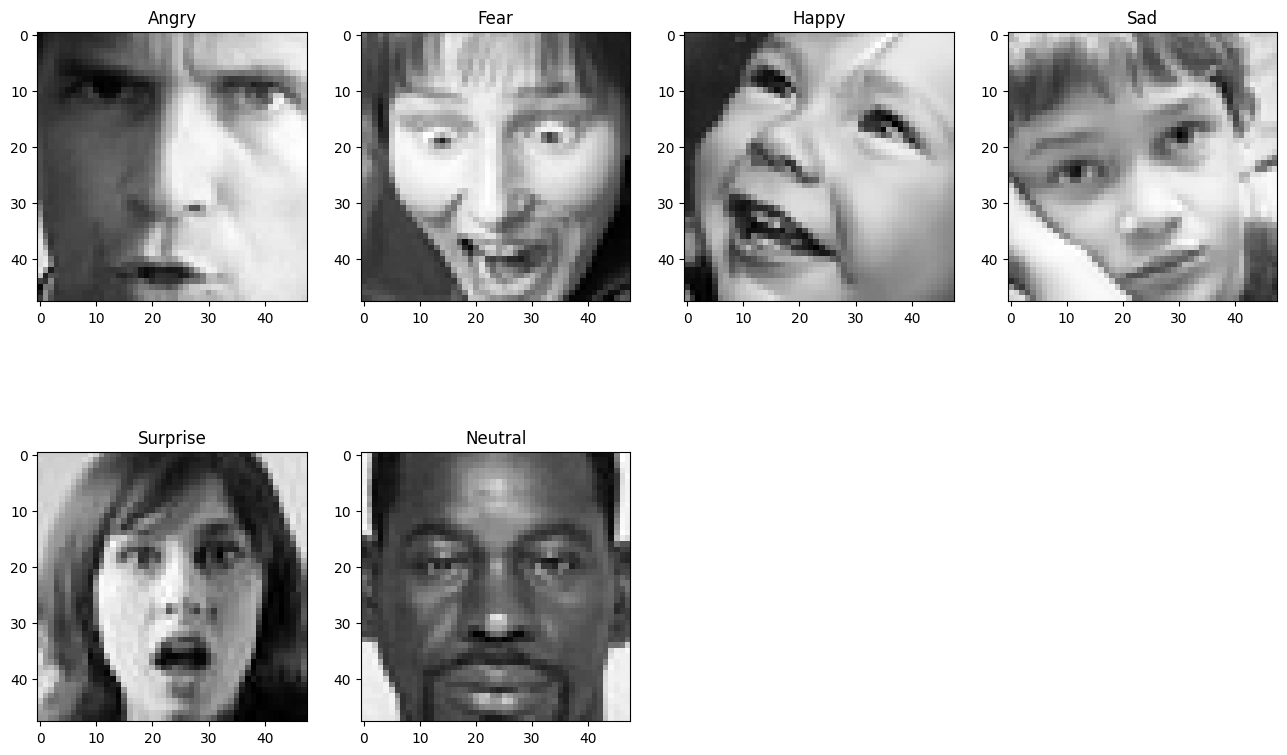

In [ ]:
plt.style.use('default')
plt.figure(0, figsize=(16,10))

for i in range(6):
    plt.subplot(2,4,i+1)
    image = plot_images(train_data,i)
    plt.imshow(image, cmap='gray')
    plt.title(emotion_num_map[i])

In [ ]:
train_data = train_data[train_data['emotion'] != 1]

In [ ]:
train_data['emotion'].value_counts()

2    7215
5    4965
3    4830
1    4097
0    3995
4    3171
Name: emotion, dtype: int64

In [ ]:
train_data.iloc[train_data['emotion'] == 5, 0] = 4

In [ ]:
train_data.head()

,emotion,pixels
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
2,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
5,3,235 233 223 109 34 37 34 31 28 38 56 69 106 13...


In [ ]:
train_data.to_csv('./drive/MyDrive/Emotion Detection/Data/filtered_test.csv', index=False)

In [ ]:
def preprocess(input_data):
    input_images = np.zeros(shape=(input_data.shape[0], 48, 48))
    for i, row in enumerate(input_data.index):
        image = np.fromstring(input_data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        input_images[i] = image

    input_images = input_images.reshape((input_images.shape[0], 48, 48, 1))
    input_images = input_images.astype('float32')/255
    input_labels = np.array(list(map(int, input_data['emotion'])))
    image_labels = to_categorical(input_labels, num_classes)
    return  input_images, image_labels

In [ ]:
train_pixels, train_labels = preprocess(train_data)
test_pixels, test_labels = preprocess(test_data)

### REGULAR CNNs

In [ ]:
def create_model():
    model = Sequential()

    model.add(Conv2D(64,(3,3),padding = 'same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
def no_category(input_data):
    input_labels = np.array(list(map(int, input_data['emotion'])))
    return input_labels

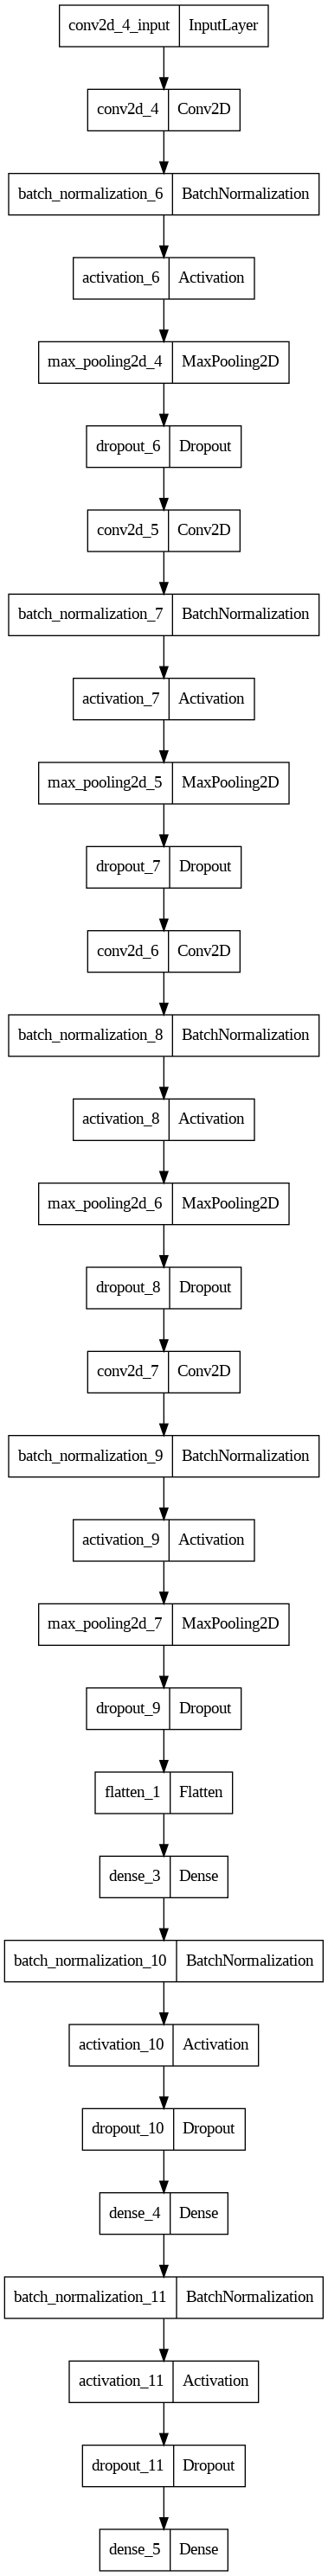

In [ ]:
keras.utils.plot_model(
    custom_model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [ ]:
custom_model = create_model()
opt = Adam(learning_rate = 0.0001)
custom_model.compile(optimizer=opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
#custom_model.build()
custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(custom_model, to_file='model.png')

In [ ]:
BATCH_SIZE = 300
EPOCH = 50

checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
hist = custom_model.fit(train_pixels, train_labels, validation_data=(test_pixels, test_labels), steps_per_epoch=228, epochs = EPOCH, callbacks=[checkpoint, reduce_learningrate])

Epoch 1/50
228/228 [==============================] - ETA: 0s - loss: 1.7241 - accuracy: 0.2874
Epoch 1: val_accuracy improved from -inf to 0.30728, saving model to ./model.h5
228/228 [==============================] - 18s 57ms/step - loss: 1.7241 - accuracy: 0.2874 - val_loss: 1.6685 - val_accuracy: 0.3073 - lr: 1.0000e-04
Epoch 2/50
227/228 [============================>.] - ETA: 0s - loss: 1.5623 - accuracy: 0.3492
Epoch 2: val_accuracy did not improve from 0.30728
228/228 [==============================] - 12s 51ms/step - loss: 1.5617 - accuracy: 0.3491 - val_loss: 1.6945 - val_accuracy: 0.2717 - lr: 1.0000e-04
Epoch 3/50
227/228 [============================>.] - ETA: 0s - loss: 1.4565 - accuracy: 0.4008
Epoch 3: val_accuracy improved from 0.30728 to 0.35194, saving model to ./model.h5
228/228 [==============================] - 12s 52ms/step - loss: 1.4563 - accuracy: 0.4008 - val_loss: 1.5416 - val_accuracy: 0.3519 - lr: 1.0000e-04
Epoch 4/50
227/228 [============================


Epoch 50: val_accuracy did not improve from 0.69562
228/228 [==============================] - 9s 40ms/step - loss: 0.7246 - accuracy: 0.7191 - val_loss: 0.7970 - val_accuracy: 0.6940 - lr: 1.2800e-09


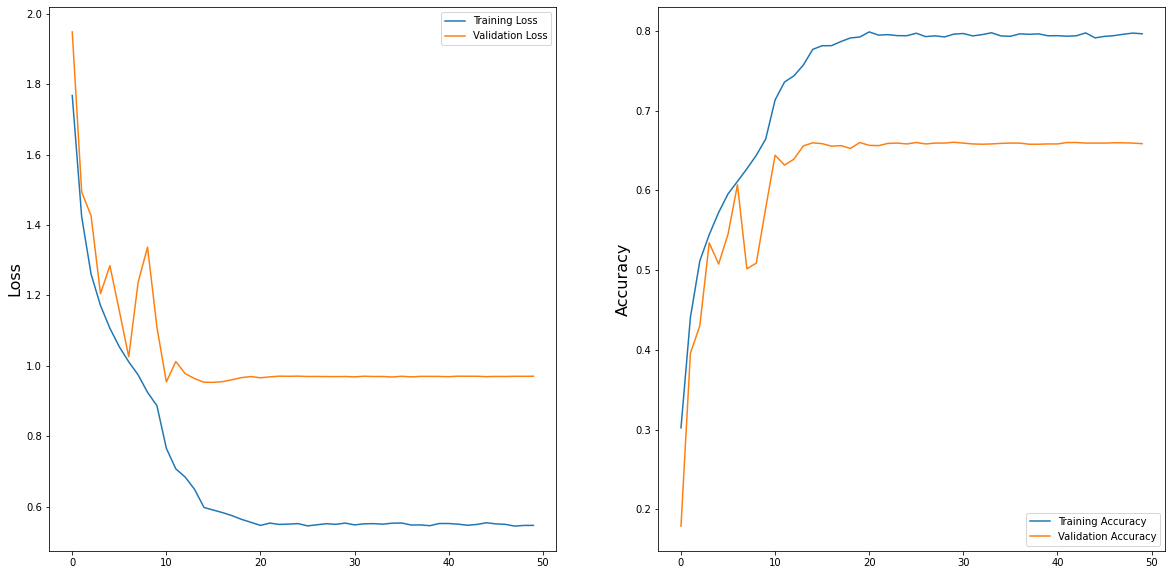

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
#plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model = load_model("/content/drive/MyDrive/Emotion Detection/Models/model.h5")

In [ ]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, emotion_num_map)
y_tests = no_category(test_data)

221/221 [==============================] - 2s 6ms/step


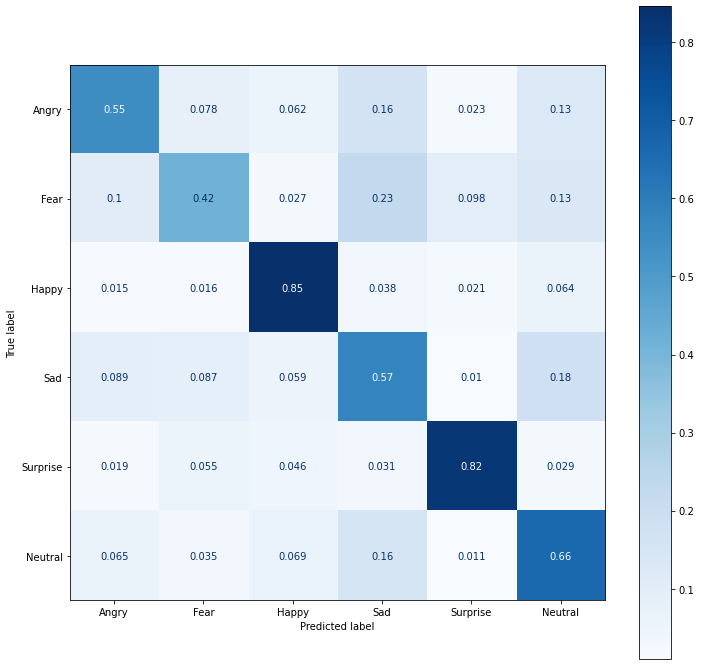

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
figsize = (12,12)
ConfusionMatrixDisplay.from_estimator(estimator=classifier, X=test_pixels, y=y_tests, cmap='Blues', normalize='true', display_labels=emotion_num_map, ax=plt.subplots(figsize=figsize)[1])

756/756 [==============================] - 5s 6ms/step


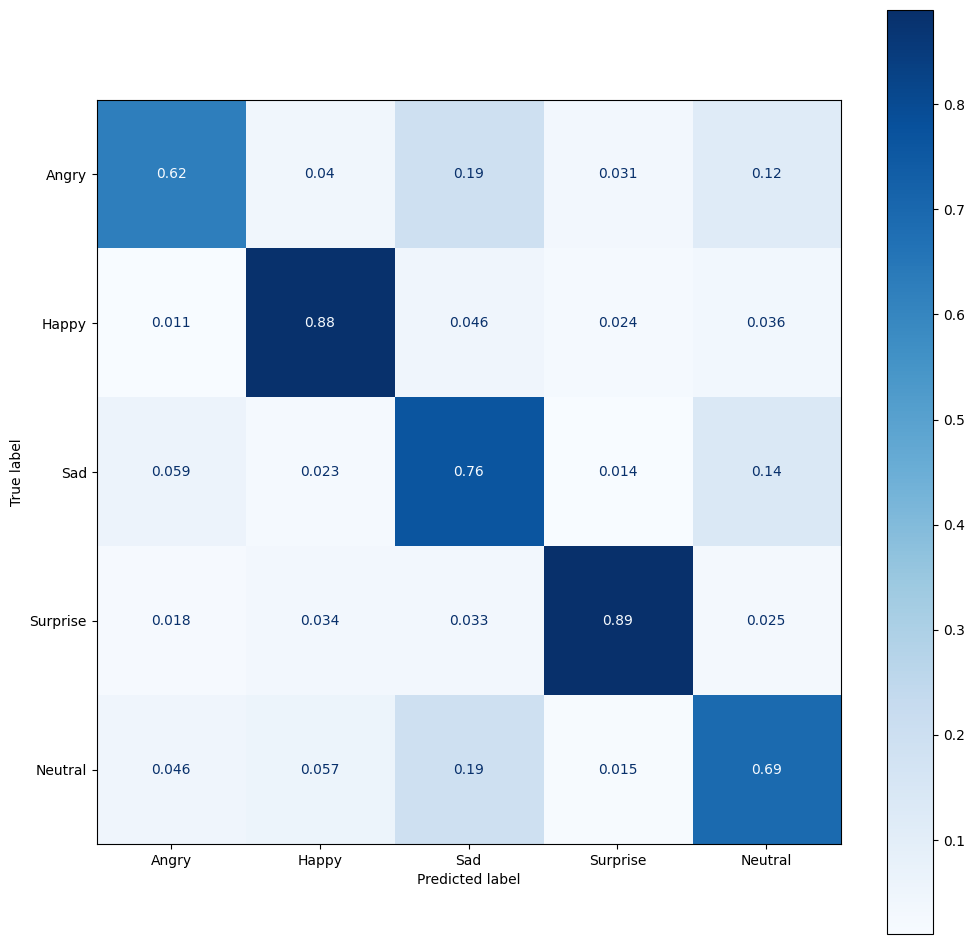

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
figsize = (12,12)
ConfusionMatrixDisplay.from_estimator(estimator=classifier, X=train_pixels, y=y_tests, cmap='Blues', normalize='true', display_labels=emotion_num_map, ax=plt.subplots(figsize=figsize)[1])

In [ ]:
custom_model.save('./drive/MyDrive/Emotion Detection/Models/model_no_disgust_emotion.h5')

In [ ]:
! mv model.h5 './drive/MyDrive/Emotion Detection/Models/'

### RESNET34

In [ ]:
def identity_block(x, filter):
    x_skip = x
    # Layer 1
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Layer 2
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization()(x)
    # Add Residue
    x = Add()([x, x_skip])     
    x = Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):
    x_skip = x
    # Layer 1
    x = Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Layer 2
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization()(x)
    # Processing Residue with conv(1,1)
    x_skip = Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    #x_skip = BatchNormalization()(x_skip)
    # Add Residue
    x = Add()([x, x_skip])     
    x = Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape = (48, 48, 1), classes = 6):
    # Step 1 (Setup Input Layer)
    x_input = Input(shape)
    # preprocessing
    #x = RandomFlip("horizontal_and_vertical")(x_input)
    #x = RandomRotation(0.2)(x)

    x = ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Step 3 Add the Resnet Blocks
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = convolutional_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    x = convolutional_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    x = convolutional_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)

    # Step 4 End Dense Network
    x = AveragePooling2D((2,2), padding = 'same')(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
model = ResNet34()
model.compile(optimizer = SGD(lr=1e-2, momentum=0.9), loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [ ]:
checkpoint = ModelCheckpoint('./model_chkpt.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=8, verbose=1)

In [ ]:
hist = model.fit(train_pixels, train_labels, epochs=30, steps_per_epoch=288, validation_split=0.1, callbacks=[checkpoint, earlystop])

Epoch 1/30
288/288 [==============================] - ETA: 0s - loss: 1.6427 - accuracy: 0.3306
Epoch 1: val_accuracy improved from -inf to 0.33098, saving model to ./model_chkpt.h5
288/288 [==============================] - 42s 73ms/step - loss: 1.6427 - accuracy: 0.3306 - val_loss: 1.7096 - val_accuracy: 0.3310
Epoch 2/30
288/288 [==============================] - ETA: 0s - loss: 1.4121 - accuracy: 0.4393
Epoch 2: val_accuracy improved from 0.33098 to 0.44059, saving model to ./model_chkpt.h5
288/288 [==============================] - 21s 73ms/step - loss: 1.4121 - accuracy: 0.4393 - val_loss: 1.4556 - val_accuracy: 0.4406
Epoch 3/30
288/288 [==============================] - ETA: 0s - loss: 1.2947 - accuracy: 0.4942
Epoch 3: val_accuracy improved from 0.44059 to 0.46535, saving model to ./model_chkpt.h5
288/288 [==============================] - 21s 74ms/step - loss: 1.2947 - accuracy: 0.4942 - val_loss: 1.3777 - val_accuracy: 0.4653
Epoch 4/30
288/288 [=============================

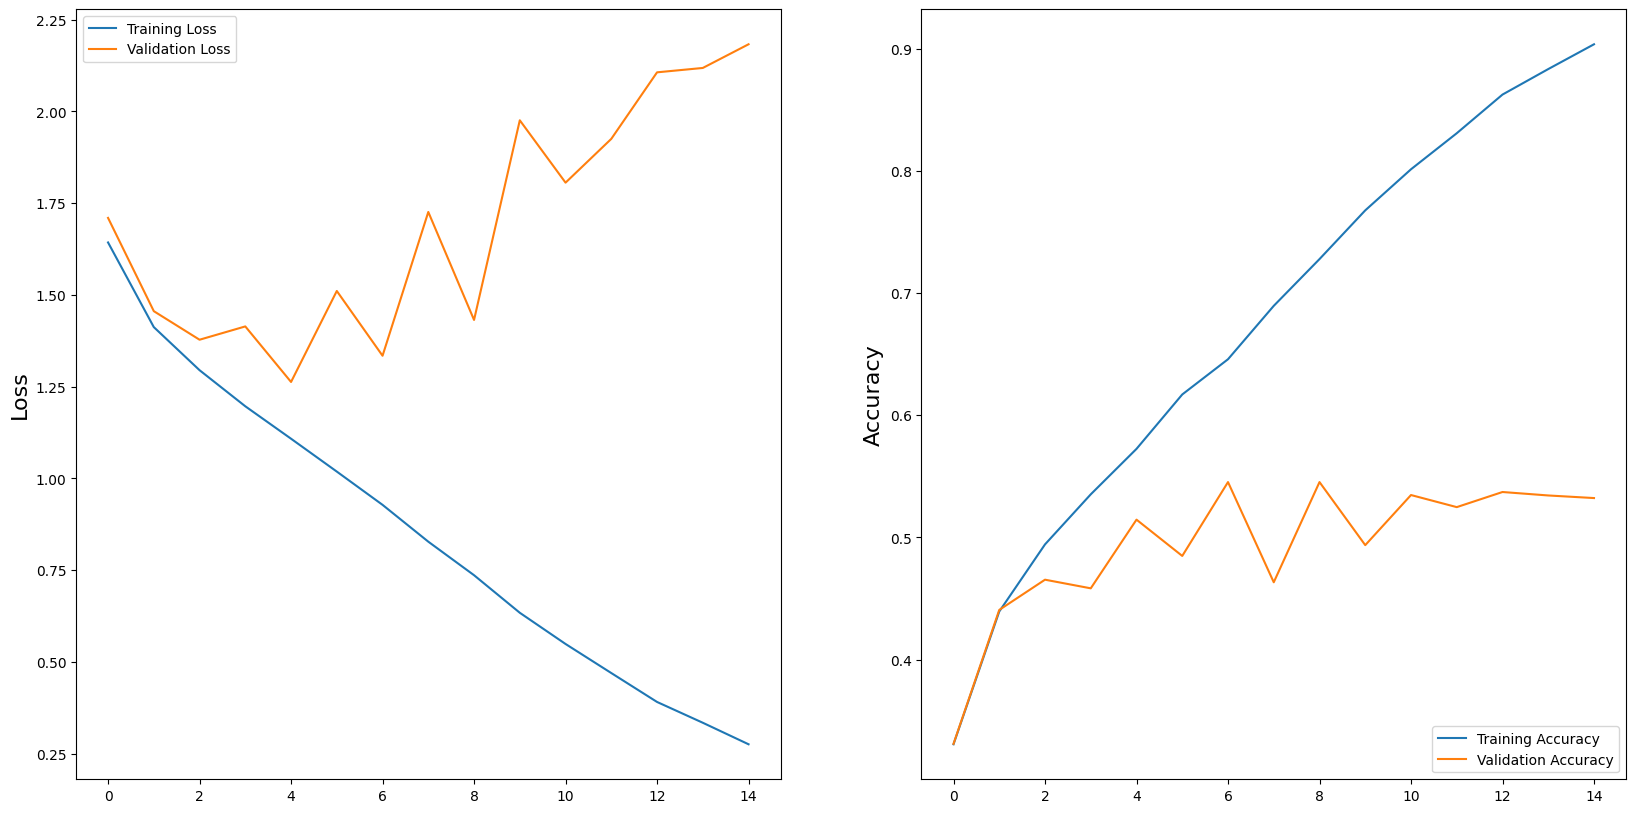

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
#plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

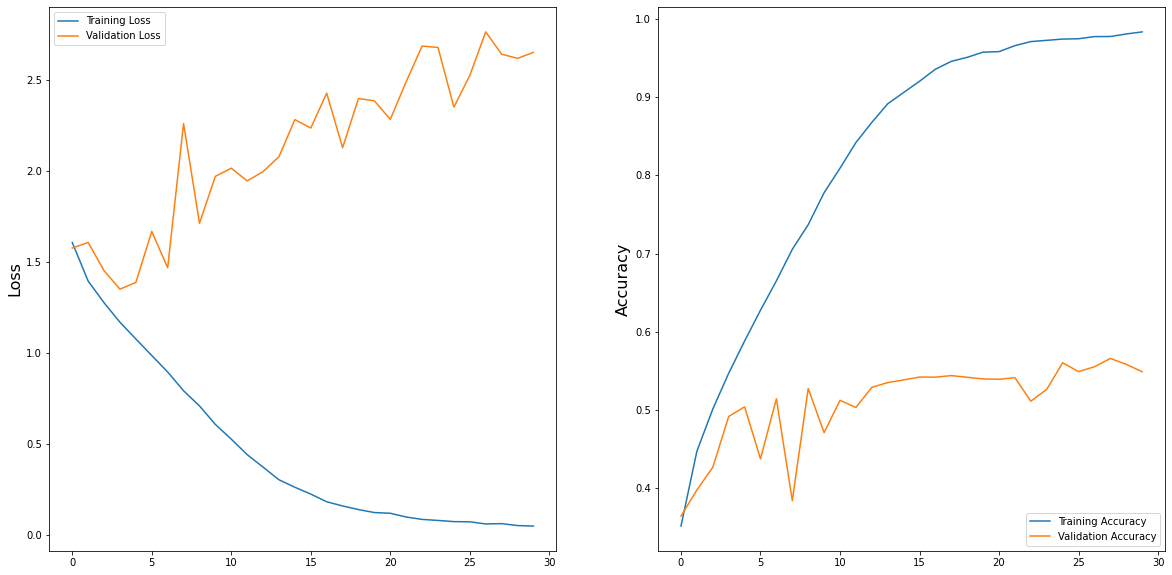

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
#plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
! mv model_chkpt.h5 './drive/MyDrive/Emotion Detection/Models/'

### RESNET50

In [ ]:
model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(48,48,1),
    classes=6,
    classifier_activation="softmax",
)
model.compile(optimizer = SGD(lr=1e-2, momentum=0.9), loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

ValueError: ignored

In [ ]:
checkpoint = ModelCheckpoint('./model_chkpt.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=8, verbose=1)

In [ ]:
hist = model.fit(train_pixels, train_labels, epochs=30, steps_per_epoch=288, validation_split=0.1, callbacks=[checkpoint, earlystop])

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
#plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()